### this is the Explotory Data Analysis of dataset. except for the "revenue" column, analyze the training set and testing set both. I walk through every each column, explore their distributions and mark the issues

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
print(df_train.shape)
print(list(df_train))
print(df_test.shape)
print(list(df_test))
# concat into one dataset
df_train['data'] = 'train'
df_test['data'] = 'test'
df = pd.concat((df_train, df_test), axis=0)
print(df.shape)
print(list(df))

(3000, 23)
['id', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue']
(4398, 22)
['id', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew']
(7398, 24)
['id', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue', 'data']


# Go through and check each column

### id: unique increment id, no nan value

In [3]:
print(df['id'].describe())
print(len(df['id'].unique()))

count    7398.000000
mean     3699.500000
std      2135.762978
min         1.000000
25%      1850.250000
50%      3699.500000
75%      5548.750000
max      7398.000000
Name: id, dtype: float64
7398


In [4]:
print(df['id'].isnull().value_counts())

False    7398
Name: id, dtype: int64


### belongs_to_collection: whether a movie belongs to a collection

In [5]:
print(df[df['data']=='train']['belongs_to_collection'].isnull().value_counts())
print(df[df['data']=='test']['belongs_to_collection'].isnull().value_counts())

True     2396
False     604
Name: belongs_to_collection, dtype: int64
True     3521
False     877
Name: belongs_to_collection, dtype: int64


In [6]:
# example
print(df['belongs_to_collection'].values[0])

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]


### budget: in US dollar, about 25% is missing, the distribution between train and test is similar

In [7]:
print(df['budget'].describe())

count    7.398000e+03
mean     2.260146e+07
std      3.694867e+07
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+06
75%      2.800000e+07
max      3.800000e+08
Name: budget, dtype: float64


In [8]:
# a lot of zero budgets, should be identified as missing
print(df[df['data']=='train']['budget'].isnull().value_counts())
print(df[df['data']=='test']['budget'].isnull().value_counts())
print(df[(df['data']=='train')&(df['budget']==0)].shape)
print(df[(df['data']=='test')&(df['budget']==0)].shape)

False    3000
Name: budget, dtype: int64
False    4398
Name: budget, dtype: int64
(812, 24)
(1211, 24)


count    5.375000e+03
mean     3.110802e+07
std      4.018026e+07
min      1.000000e+00
25%      5.053316e+06
50%      1.700000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64


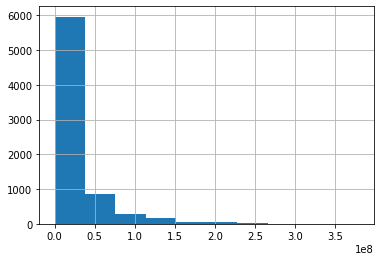

count    2.188000e+03
mean     3.089305e+07
std      4.026785e+07
min      1.000000e+00
25%      5.150000e+06
50%      1.600000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64


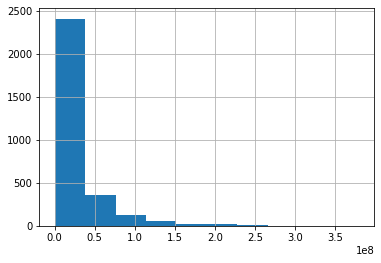

count    2.188000e+03
mean     3.089305e+07
std      4.026785e+07
min      1.000000e+00
25%      5.150000e+06
50%      1.600000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64


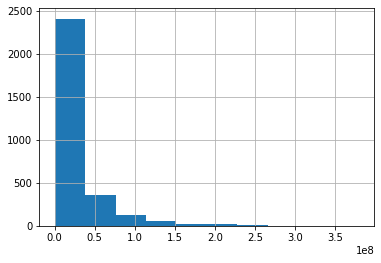

In [9]:
print(df[df['budget']!=0]['budget'].describe())
df['budget'].hist()
plt.show()
print(df_train[df_train['budget']!=0]['budget'].describe())
df_train['budget'].hist()
plt.show()
print(df_train[df_train['budget']!=0]['budget'].describe())
df_train['budget'].hist()
plt.show()

### genres: some movies has more than one genre, most non null value

In [10]:
# example
print(df['genres'].values[:10])

["[{'id': 35, 'name': 'Comedy'}]"
 "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]"
 "[{'id': 18, 'name': 'Drama'}]"
 "[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]"
 "[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]"
 "[{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]"
 "[{'id': 99, 'name': 'Documentary'}]"
 "[{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]"
 "[{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]"]


In [11]:
print(df['genres'].isnull().value_counts())
print(df_train['genres'].isnull().value_counts())
print(df_test['genres'].isnull().value_counts())

False    7375
True       23
Name: genres, dtype: int64
False    2993
True        7
Name: genres, dtype: int64
False    4382
True       16
Name: genres, dtype: int64


#### what are the total set of genres 

In [12]:
genres = []
for v in df['genres'].values:
    try:
        v = eval(v)
        for item in v:
            name = item['name']
            genres.append(name)
    except: # nan values
        continue
genres = list(set(genres))
print(genres)

['Horror', 'Thriller', 'War', 'Romance', 'Comedy', 'Documentary', 'Animation', 'Family', 'Foreign', 'Music', 'History', 'Crime', 'TV Movie', 'Western', 'Mystery', 'Fantasy', 'Adventure', 'Science Fiction', 'Action', 'Drama']


### homepage: seems useless

In [13]:
# example
print(df['homepage'].values[:3])

[nan nan 'http://sonyclassics.com/whiplash/']


### imdb_id: unique id of movie, different from id

In [14]:
print(df['imdb_id'].describe())
print(df[['id','imdb_id']][:4])

count          7398
unique         7398
top       tt2611390
freq              1
Name: imdb_id, dtype: object
   id    imdb_id
0   1  tt2637294
1   2  tt0368933
2   3  tt2582802
3   4  tt1821480


### original_language: most of the langues are concentrated

In [15]:
# example
print(df['original_language'].values[:10])
print(list(set(df['original_language'].values)))

['en' 'en' 'en' 'hi' 'ko' 'en' 'en' 'en' 'en' 'en']
['en', 'de', 'fi', 'ta', 'da', 'nl', 'xx', 'es', 'hi', 'fa', 'te', 'mr', 'bm', 'he', 'th', 'ru', 'is', 'id', 'kn', 'vi', 'ko', 'tr', 'fr', 'zh', 'no', 'hu', 'ka', 'sr', 'nb', 'pt', 'ur', 'cn', 'ro', 'bn', 'cs', 'ar', 'af', 'sv', 'ca', 'pl', 'ja', 'el', 'it', 'ml']


In [16]:
df_oriLangue = pd.concat([df['original_language'].value_counts(), df_train['original_language'].value_counts(), df_test['original_language'].value_counts()], axis=1)
df_oriLangue.columns = ['total_count', 'train_count', 'test_count']
print(df_oriLangue)

    total_count  train_count  test_count
en         6351       2575.0      3776.0
fr          199         78.0       121.0
hi          118         42.0        76.0
ru          109         47.0        62.0
es           95         43.0        52.0
ja           90         37.0        53.0
it           56         24.0        32.0
de           49         18.0        31.0
ko           49         20.0        29.0
zh           46         19.0        27.0
cn           41         20.0        21.0
ta           31         16.0        15.0
sv           20          8.0        12.0
da           17          5.0        12.0
pt           13          6.0         7.0
ml           12          2.0        10.0
nl           11          6.0         5.0
te            9          2.0         7.0
ro            9          4.0         5.0
tr            9          3.0         6.0
he            6          1.0         5.0
no            5          2.0         3.0
pl            5          2.0         3.0
fa            5 

### original_title: movie titles

In [17]:
# example
print(df['original_title'].values[:10])

['Hot Tub Time Machine 2' 'The Princess Diaries 2: Royal Engagement'
 'Whiplash' 'Kahaani' '마린보이' 'Pinocchio and the Emperor of the Night'
 'The Possession' 'Control Room' 'Muppet Treasure Island' 'A Mighty Wind']


### overview: movie overviews

In [18]:
# example
print(df['overview'].values[:3])

['When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.'
 "Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected..."
 'Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity.']


### popularity: all not null, most are small, a few of movies have very high values

count    7398.000000
mean        8.514968
std        12.165794
min         0.000001
25%         3.933124
50%         7.435844
75%        10.920002
max       547.488298
Name: popularity, dtype: float64
False    7398
Name: popularity, dtype: int64


<AxesSubplot:>

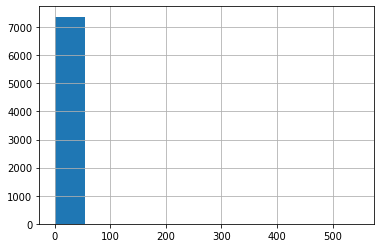

In [19]:
print(df['popularity'].describe())
print(df['popularity'].isnull().value_counts())
df['popularity'].hist()

### poster_path: url for poster, useless

In [20]:
# example
print(df['poster_path'].values[:3])

['/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg' '/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg'
 '/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg']


### production_companies: some missing values, a total of 7087 different companies

In [21]:
# example
print(df['production_companies'].values[:3])


["[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]"
 "[{'name': 'Walt Disney Pictures', 'id': 2}]"
 "[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]"]


In [22]:
print(df['production_companies'].isnull().value_counts())
print(df_train['production_companies'].isnull().value_counts())
print(df_test['production_companies'].isnull().value_counts())

False    6984
True      414
Name: production_companies, dtype: int64
False    2844
True      156
Name: production_companies, dtype: int64
False    4140
True      258
Name: production_companies, dtype: int64


In [23]:
production_companies = []
for v in df['production_companies'].values:
    try:
        v = eval(v)
        for item in v:
            name = item['name']
            production_companies.append(name)
    except: # nan values
        continue
production_companies = list(set(production_companies))
print(len(production_companies), production_companies)

7087 ['Addis Wechsler Pictures', 'Barwood Films', 'Mitsubishi', 'The Mount Company', 'Splendid Pictures', 'Seven Arts Pictures', 'Ursa Major Films LLC', 'Jerry Lewis Productions', 'Strongman', 'Pure Flix Entertainment', 'Filmkameratene A/S', 'Digit Anima', 'Concorde Pictures', 'Larry Franco Productions', 'CED Productions', 'Fries Entertainment', 'Universal International Pictures (UI)', 'Panoramic Pictures', 'Reteitalia', 'Lord Miller', 'Vulcan Productions Inc.', 'Filmax Group', 'Icon Productions', 'Really Useful Films', '26 Films', 'Everything Is Everything', 'Motion Picture Associates', 'Toei Animation', 'Epidemic Pictures', 'Aura Film Partnership', 'Off Hollywood Pictures', 'Filmex', 'Deep Films', 'Triad Film Works', 'Leverage Communications', 'Sahamongkolfilm Co.', 'Namco', 'Tezuka Production Company Ltd.', 'Pikachu Project 2001', 'Tube Pictures', 'Reposado Producciones', 'Bellanova Films', 'Decibel Films', 'Kairos', 'State Street Pictures', '369 Productions', 'National Film Develop

### release_date: format is m/d/y, the year is not 100% clear

In [165]:
# example
print(df['release_date'].values[:3])
print(df['release_date'].isnull().value_counts()) # one missing
# a preprocess, change the year format into 4 chars instead of 2, or the astype("datetime64") method will convert 69 into 2069, which is 1969
def dateTransform(dt):
    try:
        m,d,y = dt.split('/')
        if y > '20':
            y = '19'+y
        else:
            y = '20'+y
        if int(d)<10:
            d = '0'+d
        if int(m)<10:
            m = '0'+m
        res = '-'.join([y, m, d])
    except:
        res = dt
    return res
def extract_year(dt):
    try:
        return int(dt.split('-')[0])
    except:
        return dt

df['release_date_datetime64'] = [dateTransform(item) for item in df['release_date']]
df['release_year'] = [extract_year(item) for item in df['release_date_datetime64']]
print(df[['original_title','release_date','release_date_datetime64']].sort_values(by='release_date_datetime64',ascending=False))

['2/20/15' '8/6/04' '10/10/14']
False    7397
True        1
Name: release_date, dtype: int64
                  original_title release_date release_date_datetime64
2307                      Mickey       8/1/18              2018-08-01
847                    Good Time      8/11/17              2017-08-11
1274            The Glass Castle      8/10/17              2017-08-10
863                       Kidnap       8/4/17              2017-08-04
2933                  Wind River       8/3/17              2017-08-03
...                          ...          ...                     ...
2992         The Thief of Bagdad      3/18/24              1924-03-18
2925                Safety Last!       4/1/23              1923-04-01
3193               Foolish Wives      1/11/22              1922-01-11
1763                     The Kid      1/21/21              1921-01-21
828   Jails, Hospitals & Hip-Hop          NaN                     NaN

[7398 rows x 3 columns]


count    7397.00000
mean     1999.69055
std        15.34225
min      1921.00000
25%      1992.00000
50%      2004.00000
75%      2011.00000
max      2018.00000
Name: release_year, dtype: float64


<AxesSubplot:>

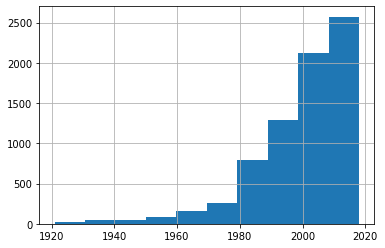

In [167]:
print(df['release_year'].describe())
df['release_year'].hist()

### runtime: in minutes, few samples missing and 0

[ 93. 113. 105.]
False    7392
True        6
Name: runtime, dtype: int64
(21, 25)
count    7392.000000
mean      107.717262
std        21.480040
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64


<AxesSubplot:>

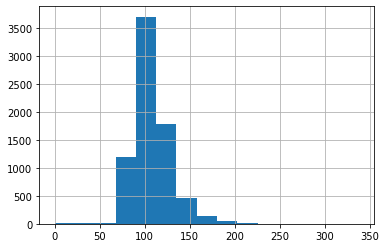

In [46]:
# example
print(df['runtime'].values[:3]) 
print(df['runtime'].isnull().value_counts()) # 6 missing
print(df[df['runtime']==0].shape) # 21 0 runtime
print(df['runtime'].describe())
df['runtime'].hist(bins=15)

### spoken_languages:  62 missing, 2285 samples have more langues than their "original_language"

In [54]:
# example
print(df['spoken_languages'].values[:3]) 
print(df['spoken_languages'].isnull().value_counts())
def process_spokenLan(item):
    try:
        item = eval(item)
        res = []
        for dic in item:
            res.append(dic['iso_639_1'])
        return ' '.join(res)
    except:
        return item
df['spoken_languages_processed'] = df['spoken_languages'].apply(process_spokenLan)
print(df[df['spoken_languages_processed']!=df['original_language']][['original_language','spoken_languages_processed']])

["[{'iso_639_1': 'en', 'name': 'English'}]"
 "[{'iso_639_1': 'en', 'name': 'English'}]"
 "[{'iso_639_1': 'en', 'name': 'English'}]"]
False    7336
True       62
Name: spoken_languages, dtype: int64
     original_language spoken_languages_processed
3                   hi                      en hi
7                   en                      ar en
13                  en                      en ru
14                  en                      en sv
16                  en                      en ru
...                ...                        ...
4384                en                      ru en
4386                en                      en de
4389                en                      en de
4391                en                      en it
4393                en             en de ja la es

[2285 rows x 2 columns]


### status: i googled the movies whose status is "Rumored" or "Post Production", i can't see what problems they have. So this column is invalid

In [57]:
# example
print(df['status'].values[:3]) 
print(df['status'].isnull().value_counts())
print(df['status'].value_counts())

['Released' 'Released' 'Released']
False    7396
True        2
Name: status, dtype: int64
Released           7385
Rumored               6
Post Production       5
Name: status, dtype: int64


In [58]:
print(df[df['status']=='Rumored'])

        id                              belongs_to_collection   budget  \
609    610  [{'id': 144200, 'name': 'Swan Princess Series'...        0   
1007  1008                                                NaN        0   
1216  1217                                                NaN        0   
1618  1619                                                NaN   891000   
102   3103                                                NaN        0   
1477  4478  [{'id': 107478, 'name': 'Lovey-Dovey Collectio...  3000000   

                                                 genres homepage    imdb_id  \
609   [{'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...      NaN  tt0120254   
1007                     [{'id': 35, 'name': 'Comedy'}]      NaN  tt1860180   
1216  [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...      NaN  tt0091024   
1618                [{'id': 99, 'name': 'Documentary'}]      NaN  tt0145394   
102   [{'id': 10749, 'name': 'Romance'}, {'id': 18, ...      NaN  tt0093104   
1477  [

In [59]:
print(df[df['status']=='Post Production'])

        id belongs_to_collection   budget  \
264   3265                   NaN        0   
847   3848                   NaN        0   
1260  4261                   NaN  6000000   
1448  4449                   NaN        0   
2585  5586                   NaN  2000000   

                                                 genres  \
264                 [{'id': 99, 'name': 'Documentary'}]   
847   [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...   
1260                      [{'id': 18, 'name': 'Drama'}]   
1448  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...   
2585  [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...   

                                       homepage    imdb_id original_language  \
264            http://thelastmountainmovie.com/  tt1787816                en   
847                      http://goodtime.movie/  tt4846232                en   
1260         http://www.whatmaisieknewmovie.com  tt1932767                en   
1448                                        NaN  tt009

### tagline: not very useful, 1460 missing

In [61]:
# example
print(df['tagline'].values[:3]) 
print(df['tagline'].isnull().value_counts())

['The Laws of Space and Time are About to be Violated.'
 "It can take a lifetime to find true love; she's got 30 days!"
 'The road to greatness can take you to the edge.']
False    5938
True     1460
Name: tagline, dtype: int64


### title: 847 samples whose "title" is different from "original_title", because most of them is not English movie.

In [69]:
# example
print(df['title'].values[:3]) 
print(df['title'].isnull().value_counts())

['Hot Tub Time Machine 2' 'The Princess Diaries 2: Royal Engagement'
 'Whiplash']
False    7395
True        3
Name: title, dtype: int64


In [70]:
print(df[df['title']!=df['original_title']][['title', 'original_title', 'original_language']])
print(df[df['title']!=df['original_title']]['original_language'].value_counts())

                                          title  \
4                                    Marine Boy   
15                                     Skinning   
30                             The Intouchables   
45                              The Double Hour   
50                              Moscow, Belgium   
...                                         ...   
4343                                     Framed   
4353  Remington and the Curse of the Zombadings   
4356                                     Raavan   
4382                                    Savages   
4397                               Vivre Sa Vie   

                                    original_title original_language  
4                                             마린보이                ko  
15                                         Šišanje                sr  
30                                    Intouchables                fr  
45                                   La doppia ora                it  
50                            Aa

### Keywords: 11930 different keywords

In [72]:
# example
print(df['Keywords'].values[:3]) 
print(df['Keywords'].isnull().value_counts())

["[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]"
 "[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]"
 "[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]"]
False    6729
True      669
Name: Keywords, dtype: int64


In [74]:
keywords = []
for v in df['Keywords'].values:
    try:
        v = eval(v)
        for item in v:
            name = item['name']
            keywords.append(name)
    except: # nan values
        continue
keywords = list(set(keywords))
print(len(keywords), keywords)

11930 ['commandant', 'teenage rebellion', 'afterworld', 'nagging mother', 'scandal', 'taxes', 'animated title sequence', 'mind and soul', 'archaeologist', 'giant insect', 'family photo', 'subway', 'bridge', 'jewish mafia', 'business woman', 'muppet', 'sex scandal', 'near-death experience', 'krampus', 'inter cultural', 'texas', 'the muppets', 'royal air force', 'platoon', 'saddam hussein', '\xa0flipping coin', 'computer animation', 'baldness', 'reading a book', 'armored car', 'righteous rage', 'alarm clock', 'battle for survival', 'minions', 'macedonia', 'union', 'los angeles', 'sell', 'jackass', 'viking', 'fantasy', 'prediction', 'out of body experience', 'creationism', 'saab', 'pin-up', 'air force one', 'ranger', 'latin', 'popular girl', 'expos√©', 'kama', 'mortal danger', 'hitchhiker', 'punishment', 'environment', 'dirt road', 'gun fight', 'foster sister', 'challenger', 'friendship bracelet', 'fondling', 'german abroad', 'magical creature', 'thunderbirds', 'shot in the torso', 'dog t

### cast: total of 76584 actors and actresses, an order in each movie is given, which is correct

In [76]:
# example
print(df['cast'].values[0]) 
print(df['cast'].isnull().value_counts())

[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character'

#### number of members in the cast of each movie

count    7372.000000
mean       21.030114
std        17.432940
min         0.000000
25%        11.000000
50%        16.000000
75%        24.000000
max       165.000000
Name: num_cast, dtype: float64


<AxesSubplot:>

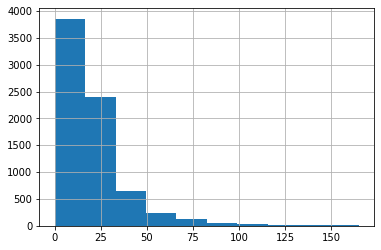

In [143]:
def count_cast(cast):
    # nan
    if isinstance(cast, str)==False:
        return cast
    else:
        return len(eval(cast))
df['num_cast'] = [count_cast(item) for item in df['cast']]
print(df['num_cast'].describe())
df['num_cast'].hist()

#### we have "id", "cast_id", "credit_id" and "name", which is the unique identidication of an actor/actress is uncertain, I think it's most likely to be "id", based on the number of unique values.

In [119]:
cast_names = []
cast_ids = []
ids = []
credit_ids = []

for v in df['cast'].values:
    try:
        v = eval(v)
        for item in v:
            cast_names.append(item['name'])
            cast_ids.append(item['cast_id'])
            ids.append(item['id'])
            credit_ids.append(item['credit_id'])
    except: # nan values
        continue
cast_names = list(set(cast_names))
cast_ids = list(set(cast_ids))
ids = list(set(ids))
credit_ids = list(set(credit_ids))
print('number of cast_names',len(cast_names))
print('number of cast_ids',len(cast_ids))
print('number of ids',len(ids))
print('number of credit_ids',len(credit_ids))



number of cast_names 75944
number of cast_ids 531
number of ids 76584
number of credit_ids 155034


#### make a dataframe of casts, columns are: 'cast_id', 'gender', 'id', 'name', 'avg_order', 'movies', 'num_movies'

In [124]:
data = []
dict_orders = {}
dict_movies = {}
for index, row in df.iterrows():
    cast = getattr(row, "cast")
    if isinstance(cast, str) == False:
        continue
    cast = eval(cast)
    movie_id = getattr(row, "id")
    for dic in cast:
        cast_id = dic['cast_id']
        gender = dic['gender']
        this_id = dic['id']
        name = dic['name']
        order = dic['order']
        movies = ''
        num_movies = 0
        data.append([cast_id, gender, this_id, name, order, movies, num_movies])
        try:
            dict_orders[this_id].append(order)
        except:
            dict_orders[this_id] = [order]
        try:
            dict_movies[this_id].append(movie_id)
        except:
            dict_movies[this_id] = [movie_id]
print(data[:2])

[[4, 2, 52997, 'Rob Corddry', 0, '', 0], [5, 2, 64342, 'Craig Robinson', 1, '', 0]]


In [129]:
df_casts = pd.DataFrame(data, columns=['cast_id', 'gender', 'id', 'name', 'avg_order', 'movies', 'num_movies']).drop_duplicates(['id']).reset_index(drop=True)
print(df_casts.shape)
print(df_casts)

(76584, 7)
       cast_id  gender       id                 name  avg_order movies  \
0            4       2    52997          Rob Corddry          0          
1            5       2    64342       Craig Robinson          1          
2            6       2    54729           Clark Duke          2          
3            7       2    36801           Adam Scott          3          
4            8       2    54812          Chevy Chase          4          
...        ...     ...      ...                  ...        ...    ...   
76579       21       0   545039       Odile Geoffroy         12          
76580       22       0    24687          Alfred Adam         13          
76581       23       0  1184410  Gis√®le Braunberger         14          
76582       24       0  1598818          Jean Ferrat         15          
76583       27       0  1052527   Jean-Paul Savignac         17          

       num_movies  
0               0  
1               0  
2               0  
3               0  


In [130]:
for i in range(df_casts.shape[0]):
    df_casts.loc[i,'avg_order'] = np.mean(dict_orders[df_casts.loc[i,'id']])
    df_casts.loc[i,'num_movies'] = len(dict_movies[df_casts.loc[i,'id']])
print(df_casts)

       cast_id  gender       id                 name  avg_order movies  \
0            4       2    52997          Rob Corddry   8.727273          
1            5       2    64342       Craig Robinson  10.470588          
2            6       2    54729           Clark Duke   8.900000          
3            7       2    36801           Adam Scott   5.320000          
4            8       2    54812          Chevy Chase   2.312500          
...        ...     ...      ...                  ...        ...    ...   
76579       21       0   545039       Odile Geoffroy  12.000000          
76580       22       0    24687          Alfred Adam  13.000000          
76581       23       0  1184410  Gis√®le Braunberger  14.000000          
76582       24       0  1598818          Jean Ferrat  15.000000          
76583       27       0  1052527   Jean-Paul Savignac  17.000000          

       num_movies  
0              22  
1              17  
2              10  
3              25  
4          

In [134]:
print(df_casts[['avg_order', 'num_movies']].describe())

          avg_order    num_movies
count  76584.000000  76584.000000
mean      22.817243      2.024365
std       21.220485      3.126478
min        0.000000      1.000000
25%        9.000000      1.000000
50%       16.000000      1.000000
75%       30.000000      2.000000
max      164.000000     80.000000


### crew

In [135]:
# example
print(df['crew'].values[0]) 

[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 1451

#### number of members in the crew of each movie

count    7360.000000
mean       24.400815
std        28.157965
min         1.000000
25%         8.000000
50%        14.000000
75%        28.000000
max       194.000000
Name: num_crew, dtype: float64


<AxesSubplot:>

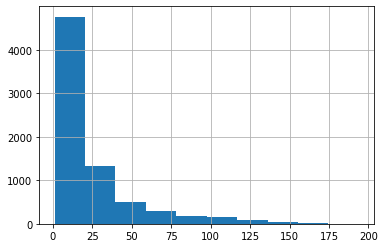

In [144]:
def count_crew(crew):
    # nan
    if isinstance(crew, str)==False:
        return crew
    else:
        return len(eval(crew))
df['num_crew'] = [count_crew(item) for item in df['crew']]
print(df['num_crew'].describe())
df['num_crew'].hist()

### revenue: is only availabe in training set, in US dollars, 1e9 is a billion

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64


<AxesSubplot:>

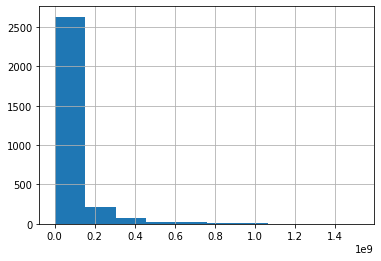

In [146]:
print(df_train['revenue'].describe())
df_train['revenue'].hist()

In [152]:
print(df[['original_title','revenue']].sort_values(by='revenue', ascending=False))

                            original_title       revenue
1126                          The Avengers  1.519558e+09
1761                             Furious 7  1.506249e+09
2770               Avengers: Age of Ultron  1.405404e+09
684                   Beauty and the Beast  1.262886e+09
2322        Transformers: Dark of the Moon  1.123747e+09
...                                    ...           ...
4393                          Original Sin           NaN
4394                      Without a Paddle           NaN
4395                           The Verdict           NaN
4396                            It Follows           NaN
4397  Vivre sa vie: film en douze tableaux           NaN

[7398 rows x 2 columns]
